In [12]:
from sklearn.cluster import KMeans
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.segmentation import slic
from skimage.color import label2rgb
import json
import matplotlib.patches as mpatches

Functions

In [ ]:
def min_max_normalize(image):
    norm_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return norm_image

def increase_contrast(image, alpha=1.5, beta=0):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def apply_gradient_mapping(image, colormap=cv2.COLORMAP_JET):
    return cv2.applyColorMap(image, colormap)

def add_noise(image, mean=0, var=0.01):
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, image.shape).astype('uint8')
    noisy_image = cv2.add(image, gauss)
    return noisy_image

def apply_dithering(image):
    return cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)

    
def plot_cluster_legend(centers, brightness_values, thresholds):
    """Creates a simple horizontal legend showing cluster colors"""
    plt.figure(figsize=(10, 2))
    
    # Sort centers by brightness
    centers_brightness = sorted(zip(centers, brightness_values), 
                             key=lambda x: x[1], 
                             reverse=True)
    sorted_centers = [center for center, _ in centers_brightness]
    
    # Create color patches in a horizontal layout
    colors = [center[::-1]/255. for center in sorted_centers]  # Convert BGR to RGB
    labels = [
        "High Density",
        "Low Density",
        "Deep Sea",
        "Land/Black"
    ]
    
    # Create legend handles
    patches = [plt.Rectangle((0,0),1,1, fc=color) for color in colors]
    
    # Plot legend
    plt.legend(patches, labels, 
              loc='center', 
              ncol=4,
              bbox_to_anchor=(0.5, 0.5))
    
    plt.axis('off')
    plt.title('Cluster Color Distribution', pad=10)
    plt.tight_layout()
    plt.show()
    
def analyze_clusters(kmeans, image_name, geo_coords, return_percentages=False):
    """
    Analyzes image clusters using brightness levels to classify water density
    Args:
        kmeans: KMeans clustering object
        image_name: Name of the image being analyzed
        geo_coords: Geographical coordinates dictionary
        return_percentages: If True, returns percentages instead of raw counts
    """
    # Get cluster centers and labels
    centers = kmeans.cluster_centers_.astype(int)
    labels = kmeans.labels_
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    # Get coordinates from polygon
    polygon_coords = geo_coords['coordinates'][0]
    
    # Dictionary to store results
    results = {
        "High Density": {"count": 0, "coords": [], "percentage": 0},
        "Low Density": {"count": 0, "coords": [], "percentage": 0},
        "Deep Sea": {"count": 0, "coords": [], "percentage": 0},
        "Land/Black": {"count": 0, "coords": [], "percentage": 0}
    }
    
    # Calculate brightness for each cluster center
    brightness_values = [np.mean(center) for center in centers]
    max_brightness = max(brightness_values)
    
    # Define brightness thresholds as percentages of max brightness
    black_threshold = 30
    deep_sea_threshold = max_brightness * 0.4
    low_density_threshold = max_brightness * 0.7
    
    # Sort clusters by brightness for analysis
    sorted_indices = np.argsort(brightness_values)[::-1]  # Sort descending
    
    # Analyze clusters based on brightness
    for idx in sorted_indices:
        center = centers[idx]
        count = counts[idx]
        brightness = brightness_values[idx]
        
        # Classify based on brightness thresholds
        if brightness < black_threshold:
            category = "Land/Black"
        elif brightness >= low_density_threshold:
            category = "High Density"
        elif brightness >= deep_sea_threshold:
            category = "Low Density"
        else:
            category = "Deep Sea"
            
        results[category]["count"] += count
        results[category]["coords"] = polygon_coords
    
    # Calculate percentages
    total_pixels = sum(count for category in results.values() for count in [category["count"]])
    
    if image_name:
        print(f"\nAnalysis for {image_name}:")
        print("=" * 70)
        print(f"Brightness Thresholds:")
        print(f"High Density: >= {low_density_threshold:.1f}")
        print(f"Low Density:  >= {deep_sea_threshold:.1f}")
        print(f"Deep Sea:     >= {black_threshold:.1f}")
        print(f"Land/Black:   < {black_threshold}")
        print("-" * 70)
        
        for category, data in results.items():
            percentage = (data["count"] / total_pixels) * 100
            results[category]["percentage"] = percentage
            
            print(f"\n{category}:")
            print(f"Pixel Count: {data['count']:,} ({percentage:.2f}%)")
            print("Geographical Region Coordinates (Long, Lat):")
            for coord in data["coords"]:
                print(f"    [{coord[0]:.6f}, {coord[1]:.6f}]")
            print("-" * 70)
    
    # Prepare thresholds dictionary for legend
    thresholds = {
        'high': low_density_threshold,
        'deep': deep_sea_threshold,
        'black': black_threshold
    }
    
    if image_name:
        # Plot the legend
        plot_cluster_legend(centers[sorted_indices], 
                          sorted(brightness_values, reverse=True),
                          thresholds)
    
    if return_percentages:
        return {k: v["percentage"] / 100 for k, v in results.items()}
    return results

def compare_densities(results_1, results_2, image1_name, image2_name):
    """
    Compares phytoplankton density between two images
    """
    print("\nComparison Results:")
    print("-" * 50)
    
    density_1 = results_1["High Density"]["percentage"]
    density_2 = results_2["High Density"]["percentage"]
    density_diff = density_1 - density_2

    if abs(density_diff) < 1:  # 5% threshold
        print("Both images have similar phytoplankton density")
    else:
        higher_density = image1_name if density_diff > 0 else image2_name
        print(f"{higher_density} shows higher phytoplankton density")
        print(f"Difference in density: {abs(density_diff):.2f}%")


def read_coordinates(filepath='coordinates.txt'):
    with open(filepath, 'r') as f:
        return json.load(f)

# Function to transform coordinates based on image transformations
def transform_coordinates(coords, original_size, new_size):
    # Get scale factors
    scale_x = new_size[0] / original_size[0]
    scale_y = new_size[1] / original_size[1]
    
    # Transform coordinates
    transformed = []
    for polygon in coords['coordinates']:
        new_polygon = []
        for point in polygon:
            new_x = point[0] * scale_x
            new_y = point[1] * scale_y
            new_polygon.append([new_x, new_y])
        transformed.append(new_polygon)
    
    return {"type": "Polygon", "coordinates": transformed}

def create_legend():
    """Creates simple legend patches for water density clusters"""
    labels = ["High Density", "Low Density", "Deep Sea", "Land/Black"]
    # Colors in RGB format
    colors = [(73/255, 173/255, 148/255),  # High density
             (43/255, 132/255, 118/255),   # Low density
             (16/255, 75/255, 91/255),     # Deep sea
             (0, 0, 0)]                    # Land/Black
    patches = [plt.Rectangle((0,0),1,1, fc=color) for color in colors]
    return patches, labels

reading image

normalize & blurring

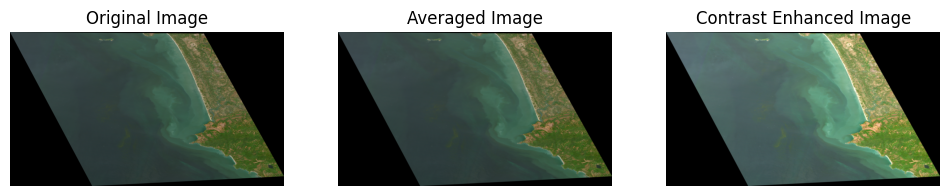

True

In [16]:
image_1_name = 'india_raw_2016.jpg'

new_size = (1920, 1080)

image_1_path = os.path.join('raw_pics_1', image_1_name)

image_1_org = cv2.imread(image_1_path)
original_size = image_1_org.shape[:2][::-1]  # Width, Height

coords = read_coordinates(r'geometry/india.txt')  # or use the provided coordinates directly
current_coords = coords.copy()

image_1_org = cv2.resize(image_1_org, new_size, interpolation=cv2.INTER_AREA)

current_coords = transform_coordinates(current_coords, original_size, new_size)

normalized_image_1 = min_max_normalize(image_1_org)

averaged_image_1 = cv2.blur(normalized_image_1, (3, 3))

image_1 = increase_contrast(averaged_image_1)

hsv_image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2HSV)
hue_1, saturation_1, value_1 = cv2.split(hsv_image_1)

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image_1_org, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(132)
plt.title('Averaged Image')
plt.imshow(cv2.cvtColor(averaged_image_1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(133)
plt.title('Contrast Enhanced Image')
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


output_dir = os.path.join('processed_images', image_1_name.split('.')[0])

os.makedirs(output_dir, exist_ok=True)

# Save contrasted image
cv2.imwrite(os.path.join(output_dir, 'contrasted_1.png'), image_1)
# Save hue channel
cv2.imwrite(os.path.join(output_dir, 'hue_1.png'), hue_1)



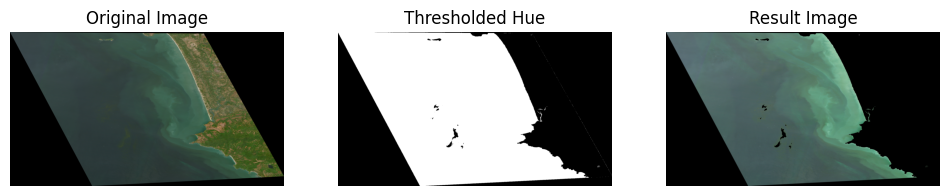

In [17]:
_, thresholded_hue_1 = cv2.threshold(hue_1,65, 255, cv2.THRESH_BINARY)
result_image_1 = cv2.bitwise_and(image_1, image_1, mask=thresholded_hue_1)


cv2.imwrite(os.path.join(output_dir, 'Adaptive Threshold Mask 1.png'), thresholded_hue_1)
cv2.imwrite(os.path.join(output_dir, 'Result Image 1.png'), result_image_1)

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image_1_org, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(132)
plt.title('Thresholded Hue')
plt.imshow(thresholded_hue_1, cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('Result Image')
plt.imshow(cv2.cvtColor(result_image_1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

C:\Users\786 COMPUTERS\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


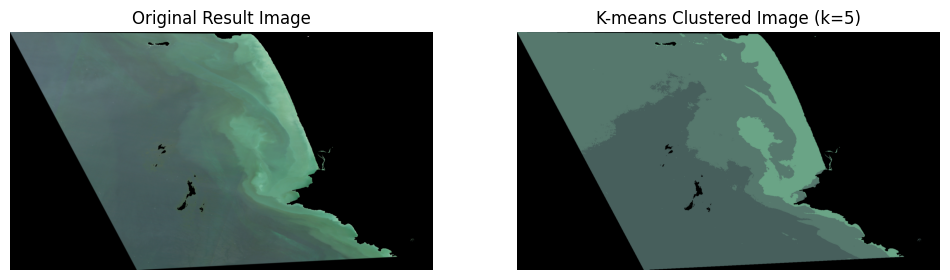

Cluster Analysis Comparison

Analysis for india_raw_2016.jpg:

High Density:
Pixel Count: 131,624 (6.35%)
Geographical Region Coordinates (Long, Lat):
    [73.936663, 15.367815]
    [74.071273, 15.000201]
    [73.749170, 14.975007]
    [73.611125, 15.371786]
    [73.936663, 15.367815]
----------------------------------------------------------------------

Low Density:
Pixel Count: 487,643 (23.52%)
Geographical Region Coordinates (Long, Lat):
    [73.936663, 15.367815]
    [74.071273, 15.000201]
    [73.749170, 14.975007]
    [73.611125, 15.371786]
    [73.936663, 15.367815]
----------------------------------------------------------------------

Deep Sea:
Pixel Count: 950,769 (45.85%)
Geographical Region Coordinates (Long, Lat):
    [73.936663, 15.367815]
    [74.071273, 15.000201]
    [73.749170, 14.975007]
    [73.611125, 15.371786]
    [73.936663, 15.367815]
----------------------------------------------------------------------


In [18]:
pixels_1 = result_image_1.reshape(-1, 3)

kmeans_1 = KMeans(n_clusters=4, random_state=42)
kmeans_1.fit(pixels_1)

clustered_pixels_1 = kmeans_1.cluster_centers_[kmeans_1.labels_]
clustered_image_kmeans_1 = clustered_pixels_1.reshape(result_image_1.shape).astype('uint8')


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Result Image')
plt.imshow(cv2.cvtColor(result_image_1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('K-means Clustered Image (k=5)')
plt.imshow(cv2.cvtColor(clustered_image_kmeans_1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


# Save hue channel
cv2.imwrite(os.path.join(output_dir, 'K-means Clustered Image 1 (k=5).png'), clustered_image_kmeans_1)

# Analyze both images
print("Cluster Analysis Comparison")
print("=" * 50)

results_1 = analyze_clusters(kmeans_1, image_1_name, coords)

# comparison

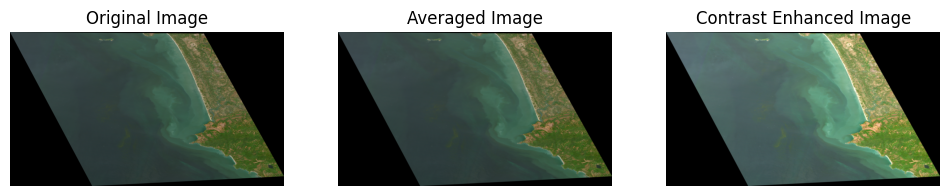

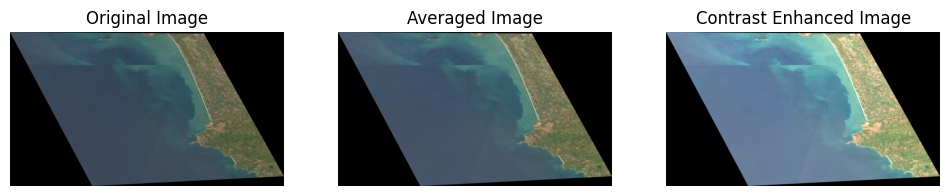

True

In [43]:
image_1_name = 'india_raw_2016.jpg'
image_2_name = "india_raw_2025.jpg"

new_size = (1920, 1080)

image_1_path = os.path.join('raw_pics_1', image_1_name)
image_2_path = os.path.join('raw_pics_2', image_2_name)

image_1_org = cv2.imread(image_1_path)
image_2_org = cv2.imread(image_2_path)

original_size = image_1_org.shape[:2][::-1]  # Width, Height

coords = read_coordinates(r'geometry/india.txt')  # or use the provided coordinates directly

current_coords = coords.copy()

image_1_org = cv2.resize(image_1_org, new_size, interpolation=cv2.INTER_AREA)
image_2_org = cv2.resize(image_2_org, new_size, interpolation=cv2.INTER_AREA)

current_coords = transform_coordinates(current_coords, original_size, new_size)

normalized_image_1 = min_max_normalize(image_1_org)
normalized_image_2 = min_max_normalize(image_2_org)

averaged_image_1 = cv2.blur(normalized_image_1, (3, 3))
averaged_image_2 = cv2.blur(normalized_image_2, (3, 3))

image_1 = increase_contrast(averaged_image_1)
image_2 = increase_contrast(averaged_image_2)

hsv_image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2HSV)
hue_1, saturation_1, value_1 = cv2.split(hsv_image_1)

hsv_image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2HSV)
hue_2, saturation_2, value_2 = cv2.split(hsv_image_2)

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image_1_org, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(132)
plt.title('Averaged Image')
plt.imshow(cv2.cvtColor(averaged_image_1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(133)
plt.title('Contrast Enhanced Image')
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image_2_org, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(132)
plt.title('Averaged Image')
plt.imshow(cv2.cvtColor(averaged_image_2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(133)
plt.title('Contrast Enhanced Image')
plt.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


output_dir = os.path.join('processed_images', image_1_name.split('.')[0])

os.makedirs(output_dir, exist_ok=True)

# Save contrasted image
cv2.imwrite(os.path.join(output_dir, 'contrasted_1.png'), image_1)
cv2.imwrite(os.path.join(output_dir, 'contrasted_2.png'), image_2)

# Save hue channel
cv2.imwrite(os.path.join(output_dir, 'hue_1.png'), hue_1)
cv2.imwrite(os.path.join(output_dir, 'hue_2.png'), hue_2)



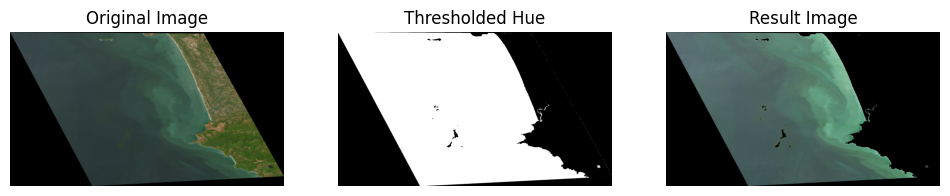

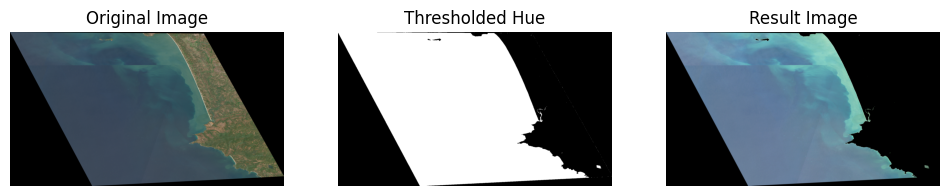

In [44]:
_, thresholded_hue_1 = cv2.threshold(hue_1,60, 255, cv2.THRESH_BINARY)
result_image_1 = cv2.bitwise_and(image_1, image_1, mask=thresholded_hue_1)

_, thresholded_hue_2 = cv2.threshold(hue_2,60, 255, cv2.THRESH_BINARY)
result_image_2 = cv2.bitwise_and(image_2, image_2, mask=thresholded_hue_2)


cv2.imwrite(os.path.join(output_dir, 'Adaptive Threshold Mask 1.png'), thresholded_hue_1)
cv2.imwrite(os.path.join(output_dir, 'Adaptive Threshold Mask 2.png'), thresholded_hue_2)

cv2.imwrite(os.path.join(output_dir, 'Result Image 1.png'), result_image_1)
cv2.imwrite(os.path.join(output_dir, 'Result Image 2.png'), result_image_2)

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image_1_org, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(132)
plt.title('Thresholded Hue')
plt.imshow(thresholded_hue_1, cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('Result Image')
plt.imshow(cv2.cvtColor(result_image_1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image_2_org, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(132)
plt.title('Thresholded Hue')
plt.imshow(thresholded_hue_2, cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('Result Image')
plt.imshow(cv2.cvtColor(result_image_2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

C:\Users\786 COMPUTERS\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\786 COMPUTERS\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


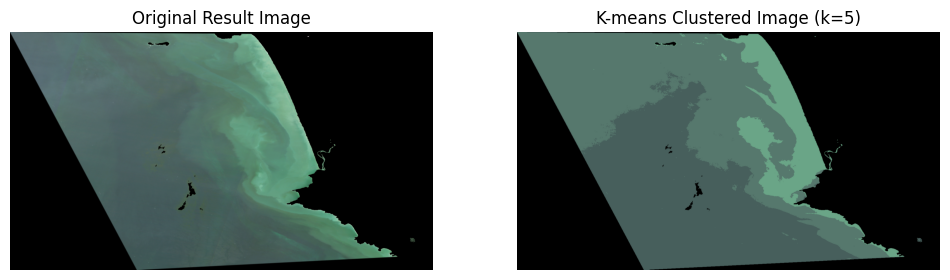

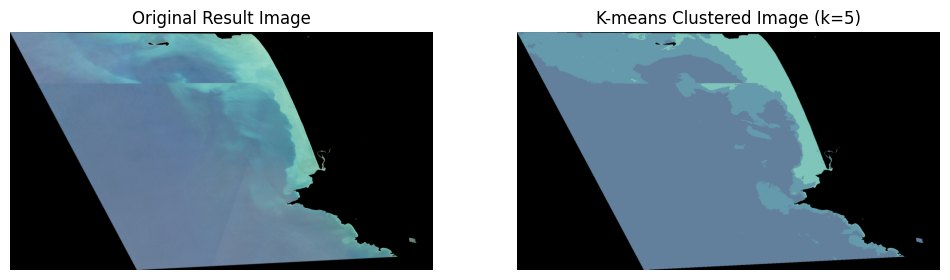

Cluster Analysis Comparison


In [45]:
pixels_1 = result_image_1.reshape(-1, 3)
pixels_2 = result_image_2.reshape(-1, 3)

kmeans_1 = KMeans(n_clusters=4, random_state=42)
kmeans_1.fit(pixels_1)

kmeans_2 = KMeans(n_clusters=4, random_state=42)
kmeans_2.fit(pixels_2)

clustered_pixels_1 = kmeans_1.cluster_centers_[kmeans_1.labels_]
clustered_image_kmeans_1 = clustered_pixels_1.reshape(result_image_1.shape).astype('uint8')

clustered_pixels_2 = kmeans_2.cluster_centers_[kmeans_2.labels_]
clustered_image_kmeans_2 = clustered_pixels_2.reshape(result_image_2.shape).astype('uint8')


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Result Image')
plt.imshow(cv2.cvtColor(result_image_1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('K-means Clustered Image (k=5)')
plt.imshow(cv2.cvtColor(clustered_image_kmeans_1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Result Image')
plt.imshow(cv2.cvtColor(result_image_2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('K-means Clustered Image (k=5)')
plt.imshow(cv2.cvtColor(clustered_image_kmeans_2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

# Save hue channel
cv2.imwrite(os.path.join(output_dir, 'K-means Clustered Image 1 (k=5).png'), clustered_image_kmeans_1)
cv2.imwrite(os.path.join(output_dir, 'K-means Clustered Image 2 (k=5).png'), clustered_image_kmeans_2)

# Analyze both images
print("Cluster Analysis Comparison")
print("=" * 50)



Analysis for india_raw_2016.jpg:
Brightness Thresholds:
High Density: >= 94.7
Low Density:  >= 54.1
Deep Sea:     >= 30.0
Land/Black:   < 30
----------------------------------------------------------------------

High Density:
Pixel Count: 634,962 (30.62%)
Geographical Region Coordinates (Long, Lat):
    [73.936663, 15.367815]
    [74.071273, 15.000201]
    [73.749170, 14.975007]
    [73.611125, 15.371786]
    [73.936663, 15.367815]
----------------------------------------------------------------------

Low Density:
Pixel Count: 490,397 (23.65%)
Geographical Region Coordinates (Long, Lat):
    [73.936663, 15.367815]
    [74.071273, 15.000201]
    [73.749170, 14.975007]
    [73.611125, 15.371786]
    [73.936663, 15.367815]
----------------------------------------------------------------------

Deep Sea:
Pixel Count: 0 (0.00%)
Geographical Region Coordinates (Long, Lat):
----------------------------------------------------------------------

Land/Black:
Pixel Count: 948,241 (45.73%)
Geo

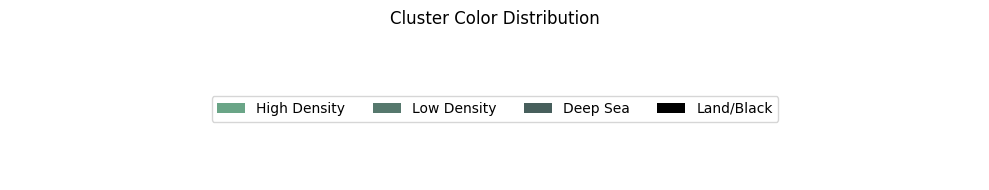


Analysis for india_raw_2025.jpg:
Brightness Thresholds:
High Density: >= 118.8
Low Density:  >= 67.9
Deep Sea:     >= 30.0
Land/Black:   < 30
----------------------------------------------------------------------

High Density:
Pixel Count: 1,129,578 (54.47%)
Geographical Region Coordinates (Long, Lat):
    [73.936663, 15.367815]
    [74.071273, 15.000201]
    [73.749170, 14.975007]
    [73.611125, 15.371786]
    [73.936663, 15.367815]
----------------------------------------------------------------------

Low Density:
Pixel Count: 0 (0.00%)
Geographical Region Coordinates (Long, Lat):
----------------------------------------------------------------------

Deep Sea:
Pixel Count: 0 (0.00%)
Geographical Region Coordinates (Long, Lat):
----------------------------------------------------------------------

Land/Black:
Pixel Count: 944,022 (45.53%)
Geographical Region Coordinates (Long, Lat):
    [73.936663, 15.367815]
    [74.071273, 15.000201]
    [73.749170, 14.975007]
    [73.611125, 

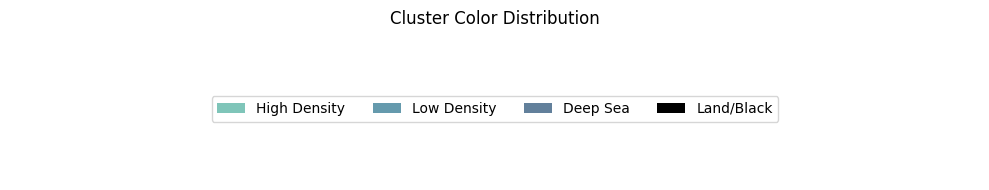


Comparison Results:
--------------------------------------------------
india_raw_2025.jpg shows higher phytoplankton density
Difference in density: 23.85%


In [46]:

results_1 = analyze_clusters(kmeans_1, image_1_name, coords)
results_2 = analyze_clusters(kmeans_2, image_2_name, coords)

compare_densities(results_1, results_2, image_1_name, image_2_name)

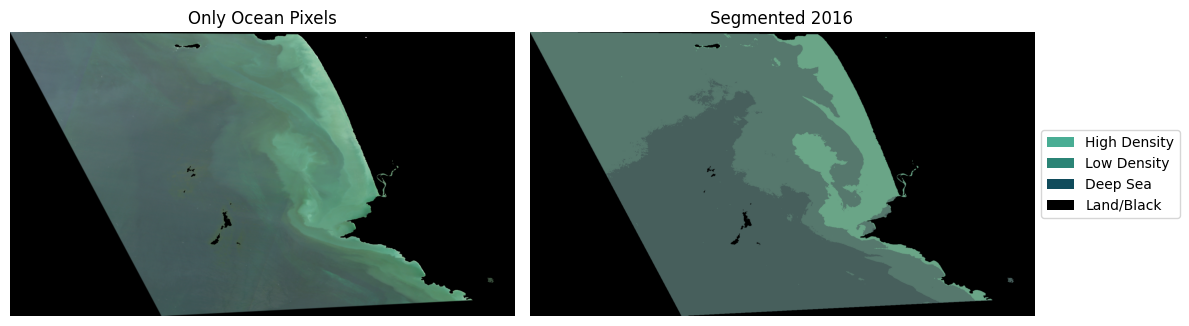

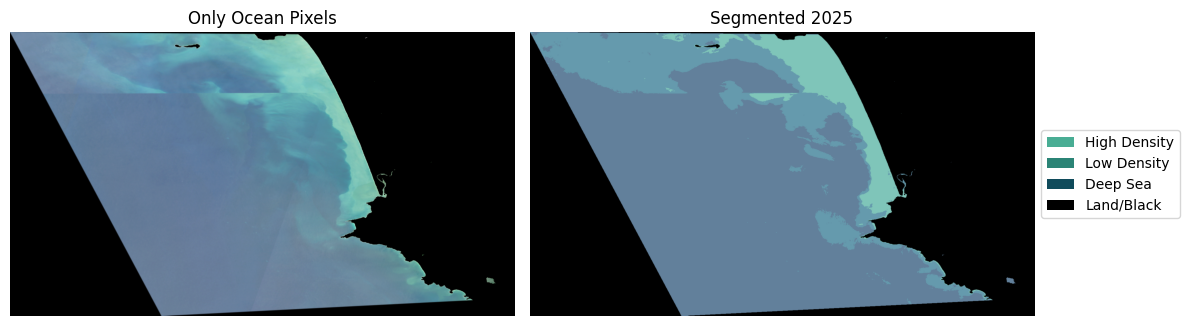

In [47]:
# Plot first image pair with legend
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Only Ocean Pixels')
plt.imshow(cv2.cvtColor(result_image_1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Segmented 2016')
plt.imshow(cv2.cvtColor(clustered_image_kmeans_1, cv2.COLOR_BGR2RGB))
patches, labels = create_legend()
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis('off')

plt.savefig(os.path.join(output_dir, 'full_frame_2016.png'), bbox_inches='tight')

plt.tight_layout()
plt.show()

# Plot second image pair with legend
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Only Ocean Pixels')
plt.imshow(cv2.cvtColor(result_image_2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Segmented 2025')
plt.imshow(cv2.cvtColor(clustered_image_kmeans_2, cv2.COLOR_BGR2RGB))
patches, labels = create_legend()
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis('off')

plt.savefig(os.path.join(output_dir, 'full_frame_2025.png'), bbox_inches='tight')

plt.tight_layout()
plt.show()
